In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import chi2
from scipy.integrate import quad

np.random.seed(42)

In [7]:
linear_func = lambda x, m, a: m * x + a
nx = 7
x = np.linspace(-5, 9, nx)
m_true = 2.6
a_true = 0.
y_true = linear_func(x, m_true, a_true)
y_dists = []
for mu in y_true:
    # add random noise to the true values
    mu = mu + np.random.normal(1, 3)
    std = np.random.uniform(1, 2)
    sample = np.random.normal(mu, std, size=10000)
    #plt.hist(sample, bins=50, density=True)
    #plt.show()
    y_dists.append(sample)

y = np.array(y_dists)

with open('x_y.pkl', 'wb') as f:
    pickle.dump((x, y), f)

# Exercises on $\chi^2$

## Fits to straight lines

The file contains a set of 7 measurements for a certain variable $x$ and, for each value of $x$, 10000 measurements of a variable $y$ normally distributed.\
Run the following cell to get the measurements:

In [8]:
import pickle
with open('x_y.pkl', 'rb') as f:
    x, y = pickle.load(f)

print(x.shape)
print(y.shape)

(7,)
(7, 10000)


Perform the following tasks:

1. Compute mean and standard deviation of each distribution and plot $x$ vs $y$ with error bars on $y$
2. Using the LSM, fit the points to the function $y = mx$:\
    2.1 Define the ```chi_square``` function\
    2.2 Plot the $\chi^2$ as a function of $m$\
    2.3 Find the value of $m$ that minimizes $\chi^2$ (i.e. the best fit of $m$)\
    2.4 Compute the 1 $\sigma$ uncertainty by finding the values of $m$ for which $\chi^2 = 1$\
    2.5 Compare the values obtained with the formulae for $m$ from the weighted least squares method\
    2.6 Plot the line that represents the best fit for both cases
3. Using the LSM, fit the points to the function $y = mx + a$ by repeating the same steps of exercise 2. The only difference is that in this case there are two parameters instead of one, so the $\chi^2$ will be a paraboloid instead of a parabola.
4. Perform a goodness of fit test using the p-value as seen during the lecture

## Solutions

In [9]:
mus = y.mean(axis=1)
stds = y.std(axis=1)

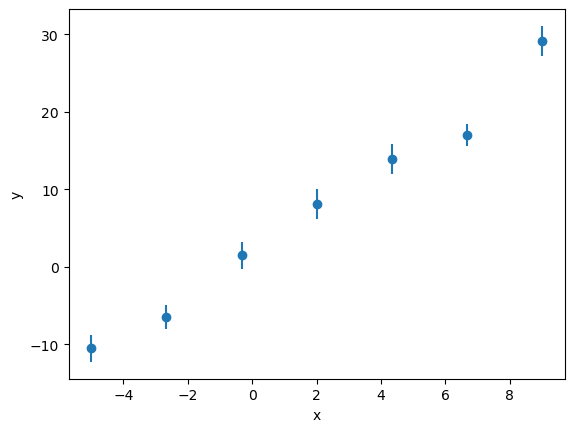

In [10]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.xlabel('x');
plt.ylabel('y');

First we fit $y = mx$:

m = 2.80 +0.13 -0.13


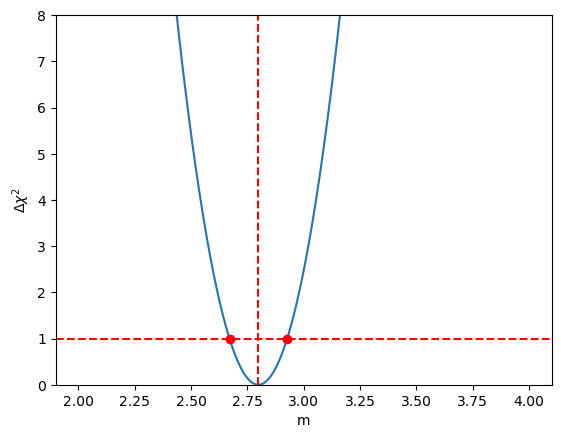

In [11]:
def chisquare(x, y, yerr, m, a):
    return np.sum(((y - linear_func(x, m, a)) / yerr) ** 2)

m_values = np.linspace(2, 4, 1000)
chi2_values_1d = np.array([chisquare(x, mus, stds, m, 0) for m in m_values])
chi2_values_1d -= chi2_values_1d.min()

# get minimum
m_best_1d = m_values[np.argmin(chi2_values_1d)]
# get 1 sigma
ml, mr = m_values[chi2_values_1d <= 1][[0, -1]]
m_left_err_1d = m_best_1d - ml
m_right_err_1d = mr - m_best_1d

# plot
plt.plot(m_values, chi2_values_1d)
plt.axvline(m_best_1d, color='red', label='m=1', linestyle='--')
plt.axhline(1, color='red', linestyle='--')
plt.plot(ml, 1, 'o', color='red')
plt.plot(mr, 1, 'o', color='red')
plt.ylim(0, 8)
plt.xlabel('m')
plt.ylabel('$\Delta\chi^2$')

print(f"m = {m_best_1d:.2f} +{m_right_err_1d:.2f} -{m_left_err_1d:.2f}")

And compare with:

$$\hat{m} = \frac{\sum w_i x_i y_i}{\sum w_i x_i^2}$$

$$\sigma_{\hat{m}} = \frac{1}{\sum w_i x_i^2}$$

where:

$$w_i = \frac{1}{\sigma_i^2}$$

In [12]:
best_m_theory_1d = np.sum(x * mus / stds**2) / np.sum(x**2 / stds**2)
sigma_m_1d = 1 / np.sqrt(np.sum(x**2 / stds**2))

print(f"a = {best_m_theory_1d:.2f} +/- {sigma_m_1d:.2f}")

a = 2.80 +/- 0.13


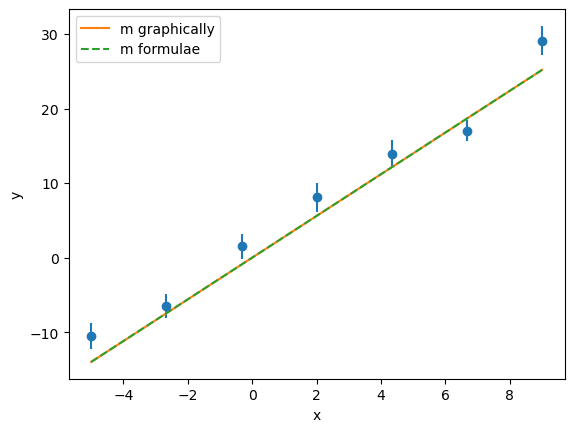

In [13]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.plot(x, linear_func(x, m_best_1d, 0), label='m graphically');
plt.plot(x, linear_func(x, best_m_theory_1d, 0), label='m formulae', linestyle='--');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

p-value = 0.88


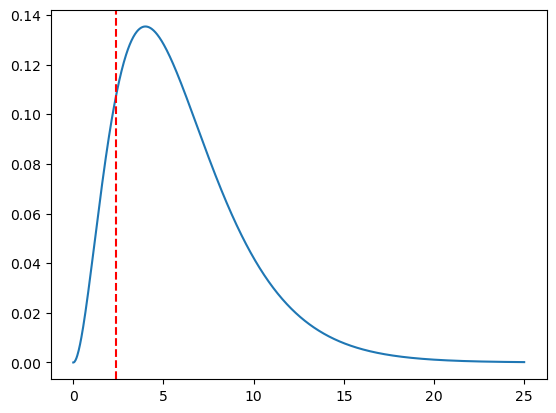

In [14]:
chi_best_1d = chisquare(x, mus, stds, m_best_1d, 0)
dof = len(x) - 1
frozen = chi2(df=dof)
x_chi = np.linspace(0, 25, 1000)
# integrate the chi2 distribution from chi_best to infinity
pval = quad(frozen.pdf, chi_best_1d/dof, np.inf)[0]

plt.plot(x_chi, frozen.pdf(x_chi));
plt.axvline(chi_best_1d / dof, color='red', linestyle='--');

print(f"p-value = {pval:.2f}")

Then we fit $y = mx + a$:

m = 2.66 +0.14 -0.14
a = 1.83 +0.70 -0.70


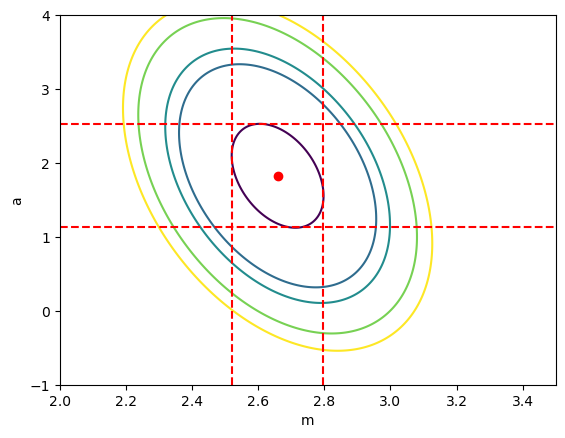

In [15]:
# define the grid of m and a values
m_values = np.linspace(2, 3.5, 1000)
a_values = np.linspace(-1, 4, 1000)
m_grid, a_grid = np.meshgrid(m_values, a_values)

chi2_values = np.zeros_like(m_grid)
for i, a in enumerate(a_values):
    for j, m in enumerate(m_values):
        chi2_values[i,j] = chisquare(x, mus, stds, m, a)
chi2_values -= chi2_values.min()
a_min_index, m_min_index = np.unravel_index(np.argmin(chi2_values), chi2_values.shape)
m_best_2d = m_values[m_min_index]
a_best_2d = a_values[a_min_index]

one_sigma_lev = 1
# find the value of chi2 with maximum m among the ones with chi2 < 1
mup = m_grid[chi2_values <= one_sigma_lev].max()
mdown = m_grid[chi2_values <= one_sigma_lev].min()
aup = a_grid[chi2_values <= one_sigma_lev].max()
adown = a_grid[chi2_values <= one_sigma_lev].min()

m_up_err_2d = mup - m_best_2d
m_down_err_2d = m_best_2d - mdown
a_up_err_2d = aup - a_best_2d
a_down_err_2d = a_best_2d - adown

# plot
plt.contour(m_values, a_values, chi2_values, levels=[one_sigma_lev, 4.61, 5.99, 9.21, 11.34]);
# plt best
plt.plot(m_best_2d, a_best_2d, 'o', color='red');
plt.xlabel('m');
plt.ylabel('a');
# plot horizontal and vertical lines for 1 sigma
plt.axvline(mdown, color='red', linestyle='--');
plt.axvline(mup, color='red', linestyle='--');
plt.axhline(adown, color='red', linestyle='--');
plt.axhline(aup, color='red', linestyle='--');

print(f"m = {m_best_2d:.2f} +{m_up_err_2d:.2f} -{m_down_err_2d:.2f}")
print(f"a = {a_best_2d:.2f} +{a_up_err_2d:.2f} -{a_down_err_2d:.2f}")

In [16]:
# cross check using curve_fit
from scipy.optimize import curve_fit
po, pcov = curve_fit(linear_func, x, mus, sigma=stds)
m_best_cf, a_best_cf = po
m_err_cf, a_err_cf = np.sqrt(np.diag(pcov))
print(f"m = {m_best_cf:.2f} +/- {m_err_cf:.2f}")
print(f"a = {a_best_cf:.2f} +/- {a_err_cf:.2f}")

m = 2.66 +/- 0.17
a = 1.83 +/- 0.86


And compare with:

$$\hat{a} = \frac{\sum wx^2 \sum wy - \sum wx \sum wxy}{\Delta}$$

$$\hat{m} = \frac{\sum w \sum wxy - \sum wx \sum wy}{\Delta}$$

$$\sigma_a = \sqrt{\frac{\sum w x^2}{\Delta}}$$

$$\sigma_m = \sqrt{\frac{\sum w}{\Delta}}$$

where

$$\Delta = \sum w \sum wx^2 - (\sum w x)^2$$

In [17]:
# formulae for m and error from theory
delta = np.sum(1 / stds ** 2) * np.sum(x ** 2 / stds ** 2) - np.sum(x / stds ** 2) ** 2

best_a_theory = (np.sum(x ** 2 / stds ** 2) * np.sum(mus / stds ** 2) - np.sum(x / stds ** 2) * np.sum(x * mus / stds ** 2)) / delta
best_m_theory = (np.sum(1 / stds ** 2) * np.sum(x * mus / stds ** 2) - np.sum(x / stds ** 2) * np.sum(mus / stds ** 2)) / delta

sigma_a_theory = np.sqrt(np.sum(x ** 2 / stds ** 2) / delta)
sigma_b_theory = np.sqrt(np.sum(1 / stds ** 2) / delta)

print('m = {:.2f} + {:.2f} - {:.2f}'.format(best_m_theory, sigma_b_theory, sigma_b_theory))
print('a = {:.2f} + {:.2f} - {:.2f}'.format(best_a_theory, sigma_a_theory, sigma_a_theory))

m = 2.66 + 0.14 - 0.14
a = 1.83 + 0.70 - 0.70


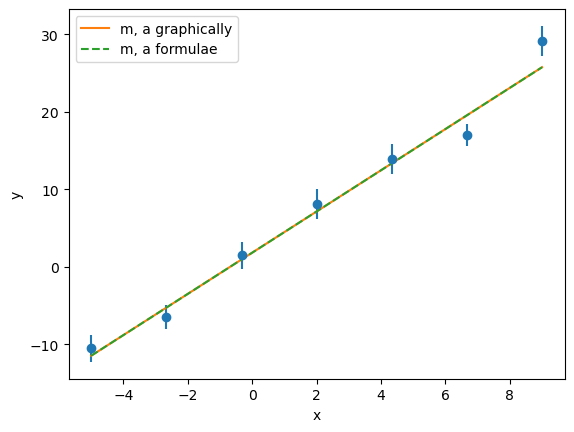

In [18]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.plot(x, linear_func(x, m_best_2d, a_best_2d), label='m, a graphically');
plt.plot(x, linear_func(x, best_m_theory, best_a_theory), label='m, a formulae', linestyle='--');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

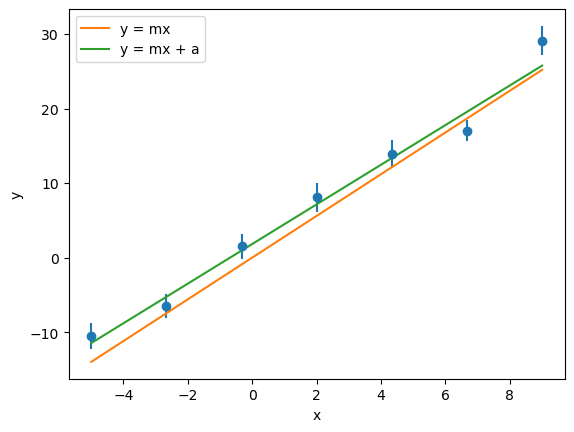

In [19]:
plt.errorbar(x, mus, yerr=stds, fmt='o');
plt.plot(x, linear_func(x, m_best_1d, 0), label='y = mx');
plt.plot(x, linear_func(x, m_best_2d, a_best_2d), label='y = mx + a');
plt.legend();
plt.xlabel('x');
plt.ylabel('y');

p-value = 0.91


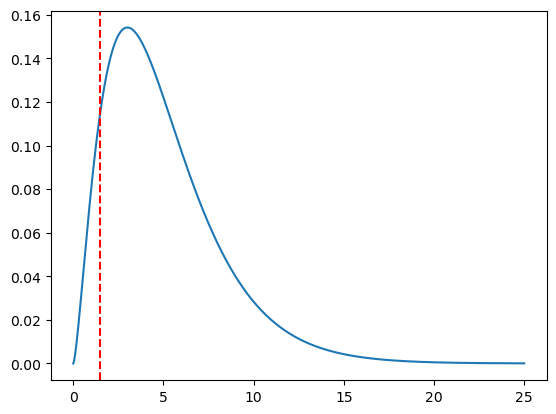

In [20]:
chi_best_2d = chisquare(x, mus, stds, m_best_2d, a_best_2d)
dof = len(x) - 2
frozen = chi2(df=dof)
x_chi = np.linspace(0, 25, 1000)
# integrate the chi2 distribution from chi_best to infinity
pval = quad(frozen.pdf, chi_best_2d/dof, np.inf)[0]

plt.plot(x_chi, frozen.pdf(x_chi));
plt.axvline(chi_best_2d/dof, color='red', linestyle='--');

print(f"p-value = {pval:.2f}")

## Fits to curves

Run the following cell to generate $x$ and $y$ points with some noise and then use one of the following ```scipy``` functions to get the best fit for the parameters along with their uncertainty:
- [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
- [least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)
- [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

In [21]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the polynomial function that we want to fit
def polynomial(x, a, b, c):
    return a*x**2 + b*x + c

# Generate some noisy data points following the polynomial function
np.random.seed(42)
xdata = np.linspace(-5, 5, 101)
ydata = polynomial(xdata, 1, -2, 1) + 0.5*np.random.normal(size=len(xdata))

Optimized parameters:
a = 1.002 +/- 0.006
b = -1.997 +/- 0.016
c = 0.928 +/- 0.069


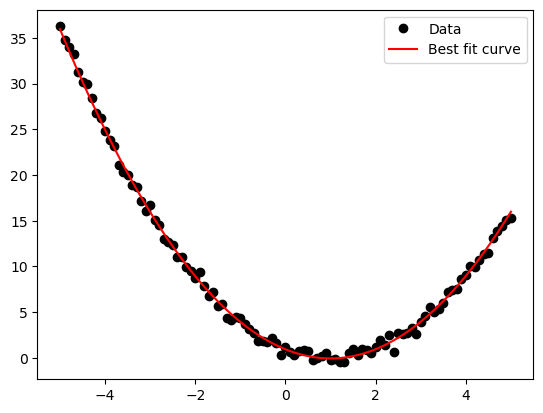

In [22]:
# Fit the data using least squares minimization
popt, pcov = curve_fit(polynomial, xdata, ydata)

# Print the optimized parameters and the 1-sigma uncertainties
print("Optimized parameters:")
print(f"a = {popt[0]:.3f} +/- {np.sqrt(pcov[0,0]):.3f}")
print(f"b = {popt[1]:.3f} +/- {np.sqrt(pcov[1,1]):.3f}")
print(f"c = {popt[2]:.3f} +/- {np.sqrt(pcov[2,2]):.3f}")

# Plot the data points and the best fit curve with error bars
plt.plot(xdata, ydata, 'ko', label='Data')
plt.plot(xdata, polynomial(xdata, *popt), 'r-', label='Best fit curve')
plt.legend()
plt.show()